# Scores

#### Imports

In [37]:
from dataclasses import dataclass
from datetime import datetime

from IPython.display import display, HTML
import httpx
from authlib.integrations.httpx_client import OAuth1Auth
from kilroyplot.plot import plt
import pandas as pd

#### Configuration

In [38]:
consumer_key = "XXXXXXXXXXXXXXXXXXXXXXXXX"
consumer_secret = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
access_token = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
access_token_secret = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

In [40]:
start = datetime(2023, 1, 1, 0, 0, 0)
end = datetime(2023, 1, 31, 0, 0, 0)

#### Data


In [41]:
@dataclass
class Tweet:
    id: int
    text: str
    created: datetime
    score: float

In [42]:
async def get_me(client):
    response = await client.get("https://api.twitter.com/2/users/me")
    response.raise_for_status()
    return response.json()["data"]

In [43]:
async def get_user_tweets(client, user):
    user_id = user["id"]
    url = f"https://api.twitter.com/2/users/{user_id}/tweets"
    pagination_token = None
    params = {"max_results": 100, "tweet.fields": "created_at,public_metrics"}

    while True:
        if pagination_token is not None:
            params["pagination_token"] = pagination_token

        response = await client.get(url, params=params)
        response.raise_for_status()

        data = response.json()["data"]
        for tweet in data:
            yield tweet

        pagination_token = response.json()["meta"].get("next_token", None)
        if pagination_token is None:
            break

In [44]:
async def get_all_my_tweets(
    consumer_key, consumer_secret, access_token, access_token_secret
):
    auth = OAuth1Auth(
        client_id=consumer_key,
        client_secret=consumer_secret,
        token=access_token,
        token_secret=access_token_secret,
    )
    async with httpx.AsyncClient(auth=auth) as client:
        me = await get_me(client)
        async for tweet in get_user_tweets(client, me):
            yield tweet

In [45]:
def encode_tweet(tweet):
    return Tweet(
        id=tweet["id"],
        text=tweet["text"],
        created=datetime.strptime(
            tweet["created_at"], "%Y-%m-%dT%H:%M:%S.%fZ"
        ),
        score=tweet["public_metrics"]["like_count"],
    )

In [46]:
async def get_tweets(
    consumer_key, consumer_secret, access_token, access_token_secret
):
    async for tweet in get_all_my_tweets(
        consumer_key, consumer_secret, access_token, access_token_secret
    ):
        yield encode_tweet(tweet)

In [47]:
tweets = [
    tweet
    async for tweet in get_tweets(
        consumer_key, consumer_secret, access_token, access_token_secret
    )
]

In [48]:
df = pd.DataFrame(
    tweets,
    columns=["text", "created", "score"],
    index=[tweet.id for tweet in tweets],
)

In [49]:
df = df[(df.created >= start) & (df.created <= end)]

#### Results

In [50]:
def plot_scores(
    df,
    x_label="Day",
    y_label="Score",
):
    data = df.groupby(pd.Grouper(key="created", freq="1D"))["score"].mean()
    x = range(1, len(data) + 1)
    y = data.values
    plt.plot(x, y, marker="o", markersize=6, linestyle="--", dashes=(2, 2))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [51]:
def print_top(df, n=30):
    top = df.sort_values("score", ascending=False)[["text", "score"]].head(n)
    display(HTML(top.to_html()))

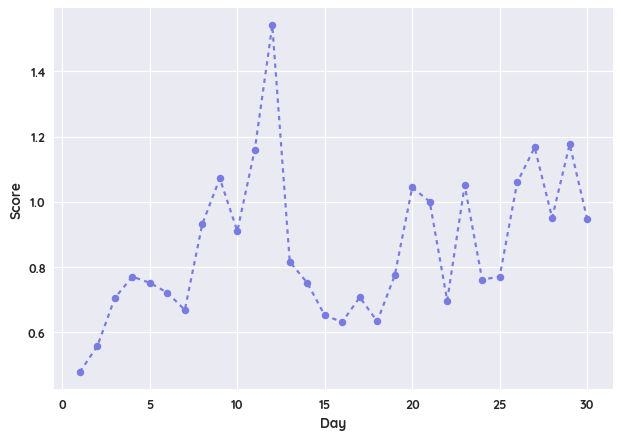

In [52]:
plot_scores(df)

In [54]:
print_top(df)

,text,score
1613030445171490816,"Lately, I'm more into music than people.",7
1614087426296643586,Happy or sad?,5
1614457444154884097,being a procrastinator with a violent fear of failure is a crazy combo,5
1613430582578397184,i’m trying my best to be okay.,5
1617363999867260935,i wanna cry of how tired i am.,5
1616337232947707909,Poor communication can seriously ruin strong connections,5
1613068195069313030,woke from the presses and needs a hug from you,5
1613423071469133826,you know you love someone when you can't hate them for breaking your heart,5
1612652988111196165,Having a trust issue is such a huge deal.,4
1612411401376514048,"in my ""nothing interested in stress"" era",4
